# Plotting with querying

## TimeSeries

In [42]:
import os
import Querying as Q
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import geopandas as gpd
import json
import geojsoncontour
import matplotlib.pyplot as plt
import holoviews as hv
import hvplot.pandas
import panel as pn
import folium
import mplleaflet

In [3]:
path = 'D:\\Repos\\PirnaCaseStudy\\Database'
database_fn = 'Database.db'
database_path = path + '\\' + database_fn

In [18]:
ts_query = Q.TimeSeries(database_path, 0)
ts_df = ts_query.DataFrame

ts_df.hvplot.scatter(
    x='Date', y='Value',
    ylabel = 'Hydraulic heads [m]',
    xlabel = 'Dates', 
    groupby = 'Name',
    width = 600,
    size = 1
)



 ******************** DataFrame already generated **********************





:DynamicMap   [Name]
   :Scatter   [Date]   (Value)

## Map

In [39]:
TileLayer = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       )



 ******************** DataFrame already generated **********************





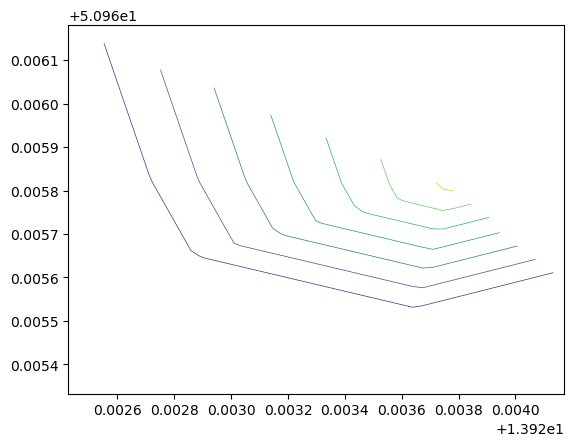

In [40]:
date = '2021-11-12'
hour = 12


date = pd.to_datetime(date)
epsg = 4326
crs = 'EPSG:{}'.format(epsg)

#querying and transforming it to geodaframe
map_query = Q.PotentiometricMap(database_path, filterVariable = 0, Year = date.year, Month = date.month, Day = date.day, FilterHour = hour)
map_df = map_query.DataFrame.dropna().reset_index(drop = True)
map_gdf = gpd.GeoDataFrame(map_df, geometry = gpd.points_from_xy (map_df.E, map_df.N), crs = crs)

# Create a geometry list from the GeoDataFrame to pass into folium map
points_list = [list(i[1].values) for i in map_gdf[['N', 'E']].iterrows()]
map_center = map_gdf.N.mean(), map_gdf.E.mean() #in folium y comes before x

#Linear interpolation
points = np.array(map_df[['E','N']])
values = np.array(map_df.Value)
minx, maxx = map_df.E.min(), map_df.E.max()
miny, maxy =  map_df.N.min(), map_df.N.max()
grid_x, grid_y = np.mgrid[minx:maxx:50j, miny:maxy:50j]
grid_z = griddata(points, values, (grid_x, grid_y), method='linear')
#contour plot
contour = plt.contour(grid_x, grid_y, grid_z, linewidths = 0.5)
#creating geodatagrame from countour
isolines_gdf = gpd.GeoDataFrame.from_features(json.loads(geojsoncontour.contour_to_geojson(
                contour=contour,
                min_angle_deg=3.0,
                ndigits=5,
                stroke_width=0.1))).set_crs(crs)

#reversing coordinates for folium (geodataframe is the contrary)
points_line = isolines_gdf.apply(lambda x: [y for y in x['geometry'].coords], axis=1)
lines_list = list()
for row in points_line:
    lines_list.append( [(tup[1], tup[0]) for tup in row])
isolines_gdf['lines'] = lines_list

#create object map and adding points to it
Map = folium.Map(location=map_center, tiles="OpenStreetMap", zoom_start=19)
Tile = TileLayer.add_to(Map)
i = 0 
for coordinates in points_list:
    # Place the markers with the popup labels and data
    Map.add_child(
        folium.Marker(
            location = coordinates,
            popup = 
                f'''
                <b>Well: </b>{map_gdf.WellName[i]}<br>
                <b>Variable:</b> {map_query.VariableName} <br>
                <b>Value: </b>{map_gdf.Value[i]}
                '''
        )
    )
    i += 1

#adding isolines 
for row in isolines_gdf.iterrows():
    row = row[1]    
    line = row.lines
    folium.PolyLine(line,
                    color = row.stroke,
                    weight = 1,
                    popup = f'''{row['level-value']}m'''
                    ).add_to(Map)

Map

### Quiver

In [59]:
from shapely.geometry import Point

In [242]:
points = np.array(map_df[['E','N']])
values = np.array(map_df.Value)
minx, maxx = map_df.E.min(), map_df.E.max()
miny, maxy =  map_df.N.min(), map_df.N.max()
grid_x, grid_y = np.mgrid[minx:maxx:50j, miny:maxy:25j]
grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

PixelSize = np.round (np.mean([grid_x[1][0] - grid_x[0][0], grid_y[0][1] - grid_y[0][0] ]), 6)
print(grid_x[1][0] - grid_x[0][0])
print( grid_y[0][1] - grid_y[0][0] )
print(PixelSize)

3.560918367284671e-05
3.54220833358454e-05
3.6e-05


In [231]:
max_ = grid_x.max(), grid_y.max()
min_ = grid_x.min(), grid_y.min()

d = {'geometry': [Point(max_), Point(min_)]}
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326").to_crs('EPSG:31469')
PixelXSize = (gdf.iloc[:,0][0].x - gdf.iloc[:,0][1].x) / 50
PixelYSize = (gdf.iloc[:,0][0].y - gdf.iloc[:,0][1].y )/ 25
PixelXSize, PixelYSize

(2.4790041340515017, 3.711351216956973)

3.560918367284671e-05

-1.734959183607998e-05

### problem Pixels have different sizes 

### Use this resolution -> 50 / 25

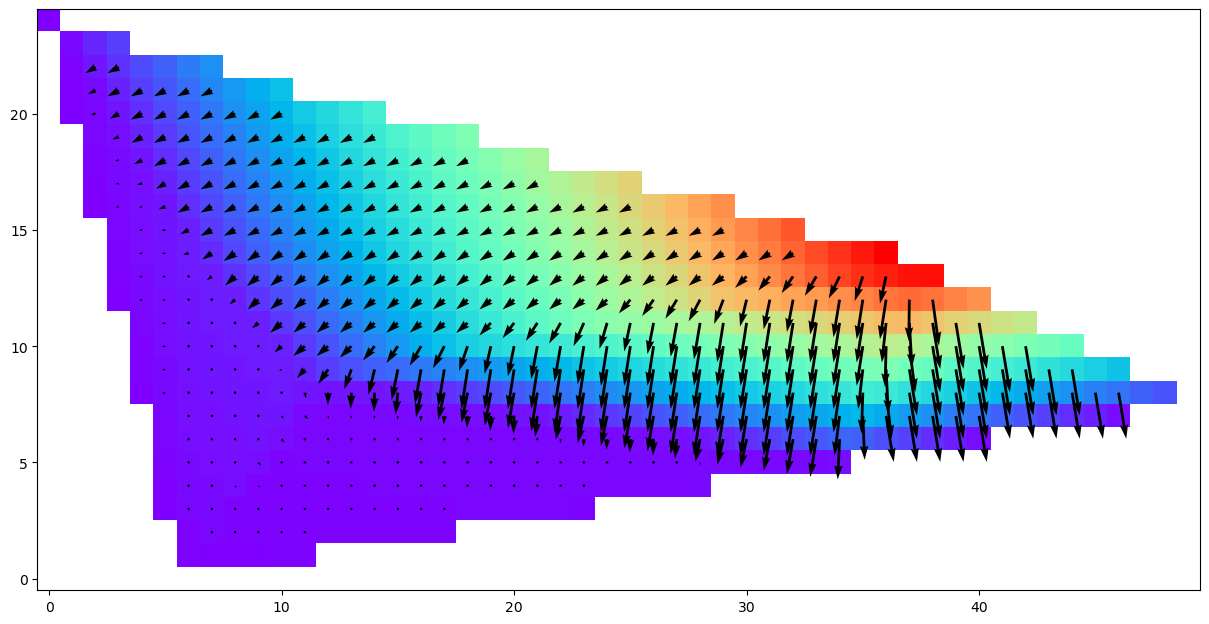

In [251]:
cellsize = PixelSize


u , v = np.gradient(grid_z, PixelSize)
# slope = np.sqrt(px ** 2 + py ** 2)
u , v = - u.T, -v.T
x_coords = np.arange(0,grid_z.shape[0],1)
y_coords = np.arange(0,grid_z.shape[1],1)
plt.figure(figsize=(15,10))
plt.imshow(grid_z.T,  cmap='rainbow'  , origin = 'lower')
# plt.title('Simple IDW power=2')
plt.quiver(x_coords,y_coords, u, v)
plt.show()

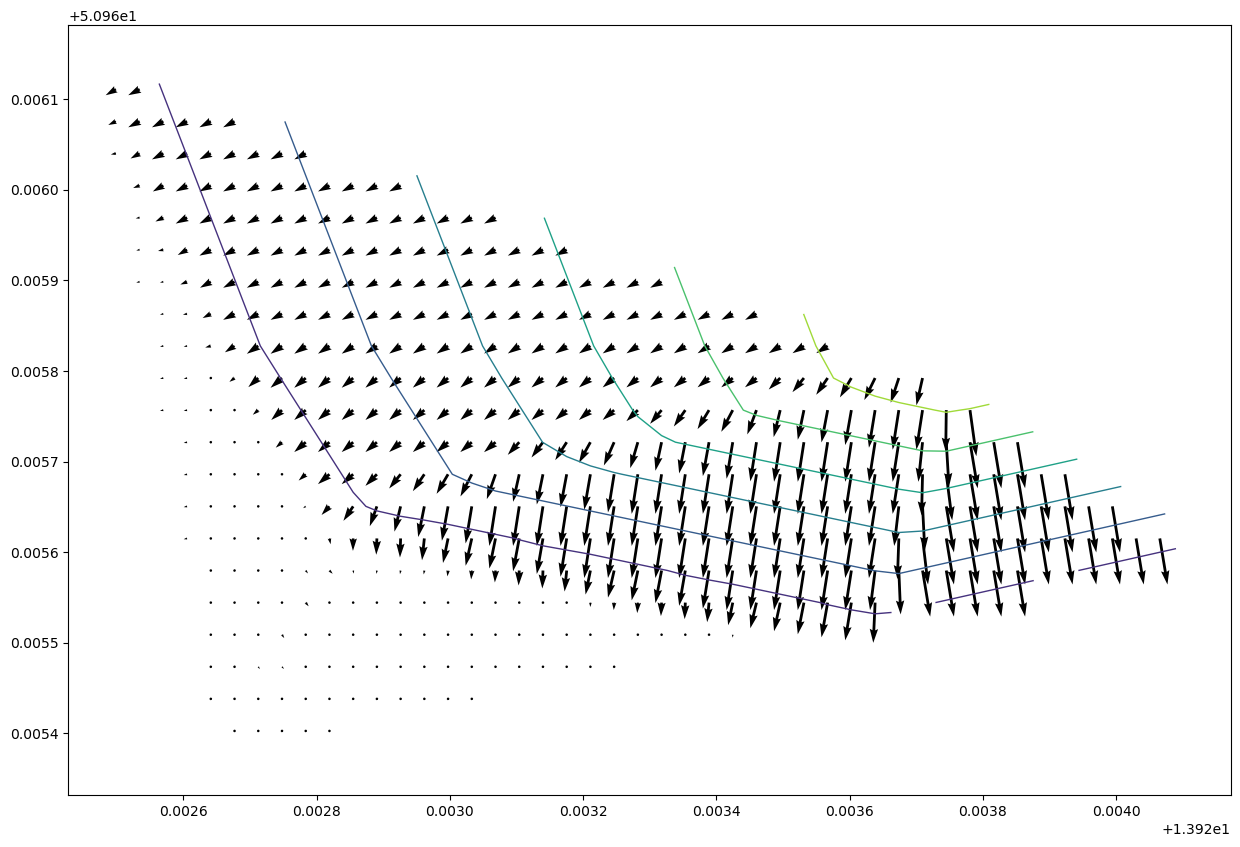

In [252]:
cellsize = PixelSize
u , v = np.gradient(grid_z, 1)
# slope = np.sqrt(px ** 2 + py ** 2)
u , v = - u.T, -v.T
x_coords = np.linspace(minx,maxx,50)
y_coords = np.linspace(miny,maxy,25)
plt.figure(figsize=(15,10))
# plt.imshow(grid_z.T,  cmap='rainbow'  , origin = 'lower')
# plt.title('Simple IDW power=2')
contour = plt.contour(grid_x, grid_y, grid_z, linewidths = 1)
plt.quiver(x_coords,y_coords, u, v)
plt.show()

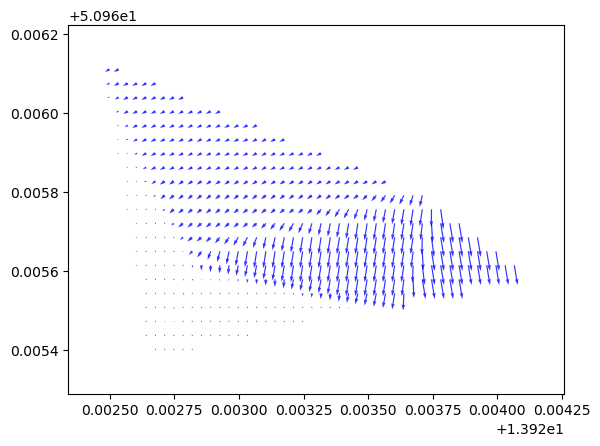

In [255]:
fig, ax = plt.subplots()
kw = dict(color = 'blue', alpha = 0.8)
q = plt.quiver(x_coords,y_coords, u, v, **kw)

AttributeError: 'XAxis' object has no attribute '_gridOnMajor'

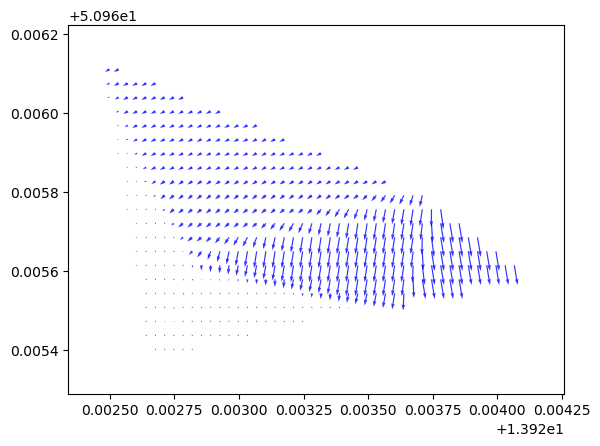

In [260]:
# plt.hold(True)
q = plt.quiver(x_coords,y_coords, u, v, **kw)
mplleaflet.display( fig = ax.figure )

In [256]:
gj = mplleaflet.fig_to_geojson(fig=fig)

AttributeError: 'XAxis' object has no attribute '_gridOnMajor'

### Add to folium

[Link](https://ocefpaf.github.io/python4oceanographers/blog/2015/11/16/folium_quiver/)

### We need to change in the database the units of hydraulic head.

1. Parse the excel again and store only the readings.

2. We can also ask them what would they prefer to store

3. Add the vectors 

## Hydrogeological profile

In [32]:
prof_df.loc[prof_df['DrillName'] == 'D-G03'].Variable.unique()

array(['K'], dtype=object)

In [37]:
prof_query = Q.HydroProfile(database_path)
prof_df = prof_query.DataFrame
prof_df.columns = ['DrillID', 'DepthSample', 'Unit', 'MethodName', 'Variable', 'Value', 'ID', 'DrillName', 'DepthDrill', 'E', 'N']
prof_df.Value = prof_df.Value.astype('float32')
prof_df2 = prof_df[['DepthSample', 'Variable', 'Value']].pivot_table(index=['DepthSample'], columns = ['Variable']).reset_index().Value
# prof_df2 = prof_df[['DepthSample', 'Variable', 'Value']].pivot_table(
#     index = 'DepthSample', columns = ['Variable']).Value.reset_index()

prof_df.hvplot.line(
    x = 'Value',
    y='DepthSample',
    ylabel =  'Depth',
    groupby = 'DrillName',
    by = 'Variable',
    width = 300,
    height = 600,
    size = 2,
    rot = 45,
    subplots = True,
    shared_axes = False
)



 ******************** DataFrame already generated **********************





C:\ProgramData\Miniconda3\lib\site-packages\holoviews\core\data\pandas.py:222: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  data = [(k, group_type(v, **group_kwargs)) for k, v in


:DynamicMap   [DrillName]
   :NdLayout   [Variable]
      :Curve   [Value]   (DepthSample)

In [86]:
prof_df

,DrillID,DepthSample,Unit,MethodName,Variable,Value,ID,DrillName,DepthDrill,E,N
0,0,0.000,mS/cm,EC logs,EC,24.500000,0,D-G01,14.0,13.922657,50.965827
1,0,0.015,mS/cm,EC logs,EC,34.750000,0,D-G01,14.0,13.922657,50.965827
2,0,0.030,mS/cm,EC logs,EC,43.380001,0,D-G01,14.0,13.922657,50.965827
3,0,0.046,mS/cm,EC logs,EC,46.689999,0,D-G01,14.0,13.922657,50.965827
4,0,0.061,mS/cm,EC logs,EC,49.340000,0,D-G01,14.0,13.922657,50.965827
...,...,...,...,...,...,...,...,...,...,...,...
977,0,14.051,mS/cm,EC logs,EC,125.550003,0,D-G01,14.0,13.922657,50.965827
978,0,14.066,mS/cm,EC logs,EC,123.269997,0,D-G01,14.0,13.922657,50.965827
979,0,14.082,mS/cm,EC logs,EC,120.639999,0,D-G01,14.0,13.922657,50.965827
980,0,14.097,mS/cm,EC logs,EC,108.820000,0,D-G01,14.0,13.922657,50.965827


# change column names in the query function